# The begin

In [1]:
import cv2
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

import scipy.stats as ss

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm

from PIL import Image, ImageDraw, ImageFont
import PIL

import os

import copy
import random
import time

import tracemalloc

%matplotlib inline

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from transformers import AutoTokenizer

In [4]:
from google.colab import drive
drive.mount('./data')

Drive already mounted at ./data; to attempt to forcibly remount, call drive.mount("./data", force_remount=True).


In [5]:
!cp /content/data/MyDrive/ColabNotebooks/Doc_recognition/Passports/pre_train.py /content
!cp /content/data/MyDrive/ColabNotebooks/Doc_recognition/Passports/models.py /content

In [6]:
cd data/MyDrive/ColabNotebooks/Doc_recognition/Passports/

/content/data/MyDrive/ColabNotebooks/Doc_recognition/Passports


In [7]:
images = os.listdir("dataset/images")

In [8]:
data = pd.read_csv("dataset/Passports.csv")
data.head()

,Unnamed: 0,file_name,H,W,channels,department,department1,department2,department3,passport_date,...,birth_place3-bottom-right-x,birth_place3-bottom-right-y,up-left-x,up-left-y,up-right-x,up-right-y,bottom-left-x,bottom-left-y,bottom-right-x,bottom-right-y
0,0,passport0.jpg,731,522,3,ЛЕСНЫМ ОМ ВЕРХНЕКАМСКОГО РАЙОНА КИРОВСКОЙ ОБЛ.,ЛЕСНЫМ ОМ ВЕРХНЕКАМСКОГО РАЙОНА,КИРОВСКОЙ ОБЛ.,NaN,27.09.2018,...,-1.0,-1.0,22.0,430.0,168.0,430.0,22.0,618.0,168.0,618.0
1,1,passport1.jpg,731,522,3,БУТКИНСКИМ ОМ ТАЛИЦКОГО РОВД СВЕРДЛОВСКОЙ ОБЛ.,БУТКИНСКИМ ОМ ТАЛИЦКОГО РОВД,СВЕРДЛОВСКОЙ ОБЛ.,NaN,15.08.2021,...,-1.0,-1.0,22.0,430.0,168.0,430.0,22.0,618.0,168.0,618.0
2,2,passport2.jpg,731,522,3,МП УФМС РОССИИ ПО САМАРСКОЙ ОБЛ. В БОЛЬШЕГЛУШИ...,МП УФМС РОССИИ ПО САМАРСКОЙ ОБЛ.,В БОЛЬШЕГЛУШИЦКОМ РАЙОНЕ Прекраной,страны России,06.01.2022,...,-1.0,-1.0,22.0,430.0,168.0,430.0,22.0,618.0,168.0,618.0
3,3,passport3.jpg,731,522,3,СЛАВЯНСКИМ ОВД КРАСНОДАРСКОГО КРАЯ Самой Прекр...,СЛАВЯНСКИМ ОВД КРАСНОДАРСКОГО,КРАЯ Самой Прекраной России двадцать,первого века,02.12.2018,...,-1.0,-1.0,22.0,430.0,168.0,430.0,22.0,618.0,168.0,618.0
4,4,passport4.jpg,731,522,3,ОТДЕЛОМ УФМС РОССИИ ПО ЧЕЛЯБИНСКОЙ ОБЛ. В Г. К...,ОТДЕЛОМ УФМС РОССИИ ПО,ЧЕЛЯБИНСКОЙ ОБЛ. В Г. КАРТАЛЫ,NaN,06.02.1992,...,-1.0,-1.0,22.0,430.0,168.0,430.0,22.0,618.0,168.0,618.0


In [9]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [10]:
classes = ['department1', 'department2', 'department3', 'passport_date', 'code', 'surname1', 'surname2', 'name', 'patron', 'sex', 'birthday', 'birth_place1', 'birth_place2', 'birth_place3', 'photo']
classes.append('blank')
coord_cols = np.array([col for col in np.hstack([data.columns[:-6], data.columns[-2:]]) if col[-2:] in ("-x", "-y")]).reshape(-1, 4)
# classes, coord_cols

In [11]:
texts = data.loc[0, classes[:-2]]
texts[pd.isnull(texts)] = ""
np.array(texts)

array(['ЛЕСНЫМ ОМ ВЕРХНЕКАМСКОГО РАЙОНА', 'КИРОВСКОЙ ОБЛ.', '',
       '27.09.2018', '433-006', 'МЕДВЕДЕВ-МЕДВЕДЕВ', '', 'МАКСИМ',
       'СЕРГЕЕВИЧ', 'МУЖ.', '27.09.2004', 'ГОР.УФА', '', ''], dtype=object)

## Датасет и даталоадер
Первая часть модели отвечает за нахождение региончиков с текстом.  
Происходит патчевая классификация. То есть таргет для картинки - это 2d тензор размера *\[H/P, W/P\]*, где для каждого патча выставлен класс, к которому от относится.  
Классов всего 16: 14 видов текстовых полей + *'photo'* + *'blank'*

In [12]:
class PassportDataset(Dataset):
    def __init__(self, pd_table, img_dir, tokenizer, w=320, h=640, p=4, from_=-1, to_=-1):
        """
        pd_table - path to the dataset
        img_dir - directory with passport images
        w, h - the desirable size of the image (to resize)
        p - patch size
        from_, to_ - set them to take a part of a dataset, not the whole
        """
        self.tokenizer = tokenizer
        self.from_ = from_
        self.data = pd.read_csv(pd_table)
        if from_ != -1 and to_ != -1:
            self.data = self.data[from_: to_]
        classes = ['blank'] + [
            'department1', 'department2', 'department3', 'passport_date', 'code', 'surname1', 'surname2', 
            'name', 'patron', 'sex', 'birthday', 'birth_place1', 'birth_place2', 'birth_place3', 'photo'
        ]
        self.classes = np.array(classes)
        self.class2id = {cls: i for i, cls in enumerate(self.classes)}
        self.coord_cols = np.array([col for col in np.hstack([self.data.columns[:-6], self.data.columns[-2:]]) if col[-2:] in ("-x", "-y")])

        self.img_dir = img_dir
        self.transforms = transforms.Compose([
                transforms.ToTensor()
            ])
        self.p = p
        self.shape = (w, h)  # shape: x, y - for PIL image
        self.pshape = (h // p, w // p)  # sape: y, x - for torch.tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        idx += self.from_
        image = PIL.Image.open(f"{self.img_dir}/{self.data.loc[idx, 'file_name']}").resize(self.shape)
        H, W = self.data.loc[idx, ["H", "W"]]
        mw, mh = self.shape[0] / W, self.shape[1] / H  # mult-W, mult-H
        tensor = self.transforms(np.array(image))
        del image
        
        fields_coords = np.array(self.data.loc[idx, self.coord_cols]).astype(np.float32).reshape(-1, 4)
        fields_coords[:, 0::2] *= mw
        fields_coords[:, 1::2] *= mh

        labels = torch.zeros(self.pshape)

        def top_left(x):
            return int(np.floor(x / self.p))
        
        def bottom_right(x):
            return int(np.ceil(x / self.p))


        # class_dct = {0: 1, 1: 1, 2: 1, 3: 2, 4: 3, 5: 4, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8, 11: 9, 12: 9, 13: 9, 14: 10}
        for k in range(len(fields_coords)):
            coords = fields_coords[k]
            if coords[0] == -1:
                continue
            labels[top_left(coords[1]): bottom_right(coords[3]), top_left(coords[0]): bottom_right(coords[2])] = k + 1  # class_dct[k]

        texts = self.data.loc[idx, self.classes[1: -1]]
        texts[pd.isnull(texts)] = ""

        texts = torch.tensor(self.tokenizer(texts.tolist(), padding="max_length", max_length=128).input_ids)

        return {"X": tensor, "target_img": labels.long(), "texts": texts}

In [13]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

In [14]:
train_data = PassportDataset("dataset/Passports.csv", "dataset/images", tokenizer, p=8, from_=0, to_=800)
test_data = PassportDataset("dataset/Passports.csv", "dataset/images", tokenizer, p=8, from_=800, to_=1000)

In [15]:
d = train_data[0]
x, y, t = d["X"], d["target_img"], d["texts"]
y = y.flatten()
print(t.shape)
torch.unique(y, return_counts=True)

torch.Size([14, 128])


(tensor([ 0,  1,  2,  4,  5,  6,  8,  9, 10, 11, 12, 15]),
 tensor([2628,   81,   39,   16,   18,   64,   18,   27,   12,   24,   21,  252]))

In [16]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [17]:
for x in train_dataloader:
    print(x["texts"].shape)
    break

torch.Size([32, 14, 128])


## Patch embeddings

In [18]:
class TwoConvLayer(nn.Module):
    """
    Special embedding layer.
    Takes a patch C x H x W
    Applies a convolution -> 1 x H' x W'
    Flattens -> H'W'
    Applies a linear layer to embed size
    """
    def __init__(self, out_size, h, w, c=3, hidden_size=3, kernel_size=3):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(c, hidden_size, kernel_size=kernel_size),
            nn.LayerNorm([hidden_size, h - kernel_size + 1, w - kernel_size + 1]),
            nn.Dropout(),
            nn.Conv2d(hidden_size, out_size, kernel_size=(h - kernel_size + 1, w - kernel_size + 1)),
        )

    def forward(self, x):
        return self.layers(x)


class NConvLayer(nn.Module):
    """
    Special embedding layer.
    Takes a patch C x H x W
    Applies a convolution -> 1 x H' x W'
    Flattens -> H'W'
    Applies a linear layer to embed size
    """
    def __init__(self, N, out_size, h, w, c=3, hidden_size=3, kernel_size=3):
        assert N > 2
        if type(hidden_size) == list:
            assert len(hidden_size) == N - 1
            hidden_size = [c] + hidden_size
        else:
            hidden_size = [c] + [hidden_size for _ in range(N - 1)]

        super().__init__()

        self.first_conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(hidden_size[i - 1], hidden_size[i], kernel_size=3, padding=1),
                nn.LayerNorm([hidden_size[i], h, w]),
                nn.Dropout(),
            ) for i in range(1, len(hidden_size) - 1)
        ])
        self.pre_last_layer = nn.Sequential(
            nn.Conv2d(hidden_size[-2], hidden_size[-1], kernel_size=kernel_size),
            nn.LayerNorm([hidden_size[-1], h - kernel_size + 1, w - kernel_size + 1]),
            nn.Dropout(),
        )
        self.final_layer = nn.Conv2d(hidden_size[-1], out_size, kernel_size=(h - kernel_size + 1, w - kernel_size + 1))

    def forward(self, x):
        for layer in self.first_conv_layers:
            x = layer(x)
        x = self.pre_last_layer(x)
        return self.final_layer(x)

    
class SimplePatchEmbedding(nn.Module):
    def __init__(self, h, w, patch_size=8, patch_embed_size=8, input_channels=3):
        assert w % patch_size == 0 and h % patch_size == 0
        super().__init__()
        self.h, self.w = h, w
        self.layers = nn.Sequential(
            nn.Conv2d(input_channels, patch_embed_size, kernel_size=patch_size, stride=patch_size),
            nn.LayerNorm([patch_embed_size, h // patch_size, w // patch_size]),
        )

    def forward(self, x):
        n_dims = len(x.shape)
        assert x.shape[3 - int(n_dims == 3)] == self.w and x.shape[2 - int(n_dims == 3)]
        return self.layers(x)

    
class NConvPatchEmbedding(nn.Module):
    def __init__(self, N, h, w, patch_size=8, patch_embed_size=8, input_channels=3, hidden_size=3, final_kernel_size=3):
        """
        w, h - size of an input image, in pixels - is needed to know the number of linear/conv layers
        """
        assert w % patch_size == 0 and h % patch_size == 0
        super().__init__()

        self.p = patch_size
        self.patch_embed_size = patch_embed_size
        self.w, self.h = w, h
        self.layer = NConvLayer(N, self.patch_embed_size, self.p, self.p, c=input_channels, hidden_size=hidden_size, kernel_size=final_kernel_size)
        self.wp, self.hp = self.w // self.p, self.h // self.p

    def forward(self, x):
        n_dims = len(x.shape)
        if n_dims == 3:
            x = x[None, :, :, :]  # Make batch if no batch
        assert x.shape[2] == self.h and x.shape[3] == self.w

        batch_size = x.shape[0]

        embedded = []
        for j in range(self.hp):
            for i in range(self.wp):
                x_patch = x[:, :, self.p * j: self.p * (j + 1), self.p * i: self.p * (i + 1)]
                embedded.append(self.layer(x_patch)[:, None, :])
        embedded = torch.stack(embedded, dim=1).reshape(batch_size, self.hp, self.wp, self.patch_embed_size).transpose(2, 3).transpose(1, 2)

        return embedded if n_dims == 4 else embedded[0]


class HeavyPatchEmbedding(nn.Module):
    def __init__(self, h, w, patch_size=8, patch_embed_size=8, input_channels=3, embed_type='linear'):
        """
        embed_size - size of embedding vectors
        pathc_size - size of a patch in pixels
        embed_type - one of ['linear', 'conv', '2conv']
        w, h - size of an input image, in pixels - is needed to know the number of linear/conv layers
        """
        assert w % patch_size == 0 and h % patch_size == 0

        super().__init__()

        self.device = device
        self.embed_size = patch_embed_size
        self.p = patch_size
        self.w, self.h, self.c = w, h, input_channels
        self.wp, self.hp = self.w // self.p, self.h // self.p
        self.embed_type = embed_type

        if self.embed_type == 'linear':
            self.layers = nn.ModuleList([nn.Linear(self.p ** 2 * self.c, self.embed_size) for _ in range(self.wp * self.hp)])
        elif self.embed_type == 'conv':
            self.layers = nn.ModuleList([nn.Conv2d(self.c, self.embed_size, kernel_size=self.p) for _ in range(self.wp * self.hp)])
        elif self.embed_type == '2conv':
            self.layers = nn.ModuleList([TwoConvLayer(self.embed_size, self.p, self.p) for _ in range(self.wp * self.hp)])
        else:
            raise ValueError("embed_type should be one of 'linear', 'conv', '2conv'")

    def forward(self, x):
        n_dims = len(x.shape)
        if n_dims == 3:
            x = x[None, :, :, :]  # Make batch if no batch
        assert x.shape[2] == self.h and x.shape[3] == self.w

        batch_size = x.shape[0]

        embedded = []
        for j in range(self.hp):
            for i in range(self.wp):
                x_patch = x[:, :, self.p * j: self.p * (j + 1), self.p * i: self.p * (i + 1)]
                if self.embed_type == 'linear':
                    x_patch = x_patch.flatten(1, -1)
                embedded.append(self.layers[self.wp * j + i](x_patch)[:, None, :])
        embedded = torch.stack(embedded, dim=1).reshape(batch_size, self.hp, self.wp, self.embed_size).transpose(2, 3).transpose(1, 2)

        return embedded if n_dims == 4 else embedded[0]


## Model

In [19]:
class PassportRecognizer(nn.Module):
    """
    На вход принимается картинка HxW
    После patch embedding будет размер (H/p)x(W/p)
    """

    def pos_embedding(self):
        x = torch.tensor([list(range(self.WP)) for _ in range(self.HP)]) / self.WP
        y = torch.tensor([list(range(self.HP)) for _ in range(self.WP)]).T / self.HP
        return torch.stack([x, y]).to(self.device)

    def __init__(
        self,
        device,
        patch_embed_layer,
        patch_size=8,
        patch_embed_size=8,
        n_classes=16,
        W=320,
        H=640,
        pos_embed=True,
        pos_embed_stack=True,
        hidden_size=None,
    ):
        self.W, self.H = W, H
        assert self.W % patch_size == 0 and self.H % patch_size == 0

        super().__init__()

        self.pos_embed = pos_embed
        self.pos_embed_stack=True
        self.device = device
        self.p = patch_size
        self.h = patch_embed_size + 2 * int(self.pos_embed and self.pos_embed_stack)
        self.WP, self.HP = self.W // self.p, self.H // self.p
        self.n_classes = n_classes
        self.hidden_size = hidden_size or self.h // 2 + 1

        self.patch_embed = patch_embed_layer
        self.norm1 = nn.Sequential(
            nn.LayerNorm([self.h, self.HP, self.WP]),
            nn.Dropout(),
        )

        self.conv_norm = nn.Sequential(
            nn.Conv2d(self.h, self.hidden_size, kernel_size=3, padding=1),
            nn.LayerNorm([self.hidden_size, self.HP, self.WP]),
            nn.Dropout(),
        )

        self.patch_to_logit = nn.Conv2d(self.hidden_size, self.n_classes, kernel_size=1)

    def forward(self, x):
        n_dims = len(x.shape)
        x = x if n_dims == 4 else x[None, :, :, :]

        x_patched = self.patch_embed(x)
        if self.pos_embed:
            if self.pos_embed_stack:
                pos_embedding = torch.stack([self.pos_embedding() for _ in range(x.shape[0])])
                x_patched = torch.concat([x_patched, pos_embedding], dim=1)
            else:
                x_patched += self.pos_embeddig()
        x_patched = self.norm1(x_patched)
        x_patched = self.conv_norm(x_patched)
        logits = self.patch_to_logit(x_patched)

        return logits if n_dims == 4 else logits[0]

## Функции train и evaluate

In [20]:
def train(model, train_data, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    for data in tqdm(train_data, desc="Training"):        
        X, y = data["X"].to(device), data["target_img"]
        texts = data["texts"]

        model.zero_grad()
        pred = model(X).to('cpu')

        pred = pred.transpose(1, 2).transpose(2, 3).flatten(0, 2)
        y = y.flatten()
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss
    return epoch_loss / len(train_data)


def evaluate(model, val_data, criterion, device):
    model.eval()
    epoch_loss = 0
    accuracy_score0, accuracy_score1 = 0, 0
    accuracy_total0, accuracy_total1 = 0, 0
    with torch.no_grad():
        for data in tqdm(val_data, desc="Evaluating"):
            X, y = data["X"].to(device), data["target_img"]
            texts = data["texts"]

            pred = model(X).to('cpu')

            pred = pred.transpose(1, 2).transpose(2, 3).flatten(0, 2)
            y = y.flatten()

            loss = criterion(pred, y)

            pred_classes = pred.argmax(dim=1)
            mask0 = y > 0
            mask1 = (y > 0) | (pred_classes > 0)
            accuracy_score0 += (y[mask0] == pred_classes[mask0]).sum()
            accuracy_total0 += len(y[mask0])
            accuracy_score1 += (y[mask1] == pred_classes[mask1]).sum()
            accuracy_total1 += len(y[mask1])

            epoch_loss += loss

    return epoch_loss / len(val_data), (accuracy_score0 / accuracy_total0, accuracy_score1 / accuracy_total1)

## Обучение itself

In [ ]:
!pip install torch_optimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
import torch_optimizer as toptim

In [ ]:
import time
import gc


def cleanup():
    gc.collect()
    torch.cuda.empty_cache()


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_classes = 16
iteration = 5

model = PassportRecognizer(
    device,
    NConvPatchEmbedding(
        3,
        640,
        320,
        patch_embed_size=16,
        hidden_size=[8, 8],
    ),
    pos_embed_stack=True,
    patch_size=8,
    patch_embed_size=16,
    hidden_size=16,
    n_classes=n_classes,
)

if iteration > 0:
    if device == 'cuda':
        model.load_state_dict(torch.load(f'models_backups/regions_extractor_latest_{iteration - 1}.pt'))
    else:
        model.load_state_dict(torch.load(f'models_backups/regions_extractor_latest_{iteration - 1}.pt', map_location=torch.device('cpu')))
model.to(device)

class_weights = [
    1.,  # blank
    100.,  # department-1 
    200.,  # department-2
    250.,  # department-3
    100.,  # passport date
    100.,  # department code
    100.,  # surname-1
    150.,  # surname-2
    100.,  # name
    100.,  # last name
    100.,  # sex
    100.,  # birth date
    100.,  # birth place 1
    150.,  # birth place 2
    200.,  # birth place 3
    100.,  # photo
]

criterion = nn.CrossEntropyLoss()

lrs = [1e-2, 1e-3, 1e-3, 3e-4, 1e-4, 1e-5]
optimizer = optim.Adam(model.parameters(), lr=lrs[iteration if iteration < len(lrs) else -1])
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

f"Working om {device}"

'Working om cuda'

In [ ]:
EPOCHS = 10
train_loss_storage, valid_loss_storage = [], []

valid_loss, accuracy_score = evaluate(model, test_dataloader, criterion, device)
print('Before training')
print(f'\t Val. Loss: {valid_loss:.3f}')
print(f'\t Where target not zero. Val. Accuracy: {accuracy_score[0]:.3f}')
print(f'\t Where target or pred not zero. Val. Accuracy: {accuracy_score[1]:.3f}')

best_valid_loss = valid_loss

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Before training
	 Val. Loss: 0.033
	 Where target not zero. Val. Accuracy: 0.941
	 Where target or pred not zero. Val. Accuracy: 0.930


In [ ]:
for epoch in range(EPOCHS):
    print(f"Epoch #{epoch + 1}")
    start_time = time.monotonic()

    train_loss = train(model, train_dataloader, criterion, optimizer, device)
    train_loss_storage.append(train_loss)

    valid_loss, accuracy_score = evaluate(model, test_dataloader, criterion, device)
    valid_loss_storage.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f'models_backups/regions_extractor_best_{iteration}.pt')
    torch.save(model.state_dict(), f'models_backups/regions_extractor_latest_{iteration}.pt')    

    # lr_scheduler.step()
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')
    print(f'\t Where target not zero. Val. Accuracy: {accuracy_score[0]:.3f}')
    print(f'\t Where target or pred not zero. Val. Accuracy: {accuracy_score[1]:.3f}')

    cleanup()

Epoch #1


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 54s
	Train Loss: 0.063
	 Val. Loss: 0.032
	 Where target not zero. Val. Accuracy: 0.941
	 Where target or pred not zero. Val. Accuracy: 0.930
Epoch #2


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 51s
	Train Loss: 0.063
	 Val. Loss: 0.032
	 Where target not zero. Val. Accuracy: 0.942
	 Where target or pred not zero. Val. Accuracy: 0.931
Epoch #3


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 51s
	Train Loss: 0.063
	 Val. Loss: 0.032
	 Where target not zero. Val. Accuracy: 0.940
	 Where target or pred not zero. Val. Accuracy: 0.930
Epoch #4


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 52s
	Train Loss: 0.063
	 Val. Loss: 0.032
	 Where target not zero. Val. Accuracy: 0.942
	 Where target or pred not zero. Val. Accuracy: 0.931
Epoch #5


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 52s
	Train Loss: 0.063
	 Val. Loss: 0.032
	 Where target not zero. Val. Accuracy: 0.940
	 Where target or pred not zero. Val. Accuracy: 0.929
Epoch #6


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 53s
	Train Loss: 0.063
	 Val. Loss: 0.032
	 Where target not zero. Val. Accuracy: 0.941
	 Where target or pred not zero. Val. Accuracy: 0.930
Epoch #7


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 52s
	Train Loss: 0.063
	 Val. Loss: 0.033
	 Where target not zero. Val. Accuracy: 0.940
	 Where target or pred not zero. Val. Accuracy: 0.929
Epoch #8


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 52s
	Train Loss: 0.063
	 Val. Loss: 0.032
	 Where target not zero. Val. Accuracy: 0.941
	 Where target or pred not zero. Val. Accuracy: 0.930
Epoch #9


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 52s
	Train Loss: 0.063
	 Val. Loss: 0.032
	 Where target not zero. Val. Accuracy: 0.941
	 Where target or pred not zero. Val. Accuracy: 0.930
Epoch #10


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 54s
	Train Loss: 0.063
	 Val. Loss: 0.032
	 Where target not zero. Val. Accuracy: 0.939
	 Where target or pred not zero. Val. Accuracy: 0.929


## Проверим глазами

In [ ]:
transforms_ = transforms.ToTensor()

image = PIL.Image.open("dataset/images/passport567.jpg").resize((320, 640))
tensor = transforms_(np.array(image)).to(device)

plt.imshow(image)

NameError: ignored

In [ ]:
plt.imshow(tensor.to('cpu').transpose(0, 1).transpose(1, 2))

In [ ]:
predictions = model(tensor).to('cpu').argmax(dim=0)
predictions.shape

In [ ]:
plt.imshow(predictions)

In [ ]:
x, y = train_data[567]

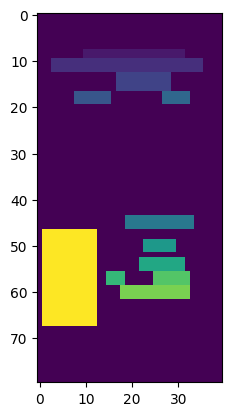

In [ ]:
plt.imshow(y)

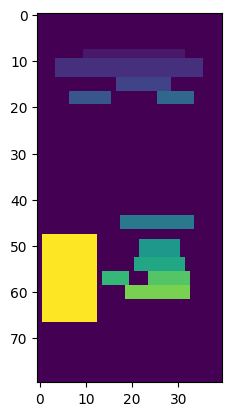

In [ ]:
predictions = model(tensor).to('cpu').argmax(dim=0)

for k in range(1, 16):
    vy, vx = torch.where(predictions == k)
    if len(vx) == 0:
        continue
    xmin, xmax = torch.quantile(vx.type(torch.float32), q=torch.tensor([0.05, 0.95]), interpolation='lower')
    predictions[vy, vx] = 0
    if k == 15:
        ymin, ymax = torch.quantile(vy.type(torch.float32), q=torch.tensor([0.05, 0.95]), interpolation='lower')
        predictions[int(ymin): int(ymax) + 1, int(xmin): int(xmax) + 1] = k
    else:
        y_vals, y_counts = torch.unique(vy, return_counts=True)
        i, j = 0, len(y_vals) - 1
        while i < j and y_vals[j] - y_vals[i] > 3:
            if y_counts[i] < y_counts[j]:
                i += 1
            else:
                j -= 1
        ymin, ymax = y_vals[i], y_vals[j]
        predictions[int(ymin): int(ymax) + 1, int(xmin) - 1: int(xmax) + 2] = k
plt.imshow(predictions)

## Для нормальной кластеризаци
Пройдём по трейн датасету и посмотрим, какие размеры в патчах имеют те или иные поля
Особенно нам интересны значения по высоте

In [ ]:
y_vals = [0 for _ in range(16)]
for i in range(len(train_data)):
    x, y = train_data[i]
    for k in range(1, 16):
        vy, vx = torch.where(y == k)
        if len(vx) > 0:
            y_vals[k] = max(y_vals[k], vy.max() - vy.min())

## Подготовка к распознаванию

### Модель для кроппинга и составления батчей из кропов

In [21]:
class ImageCropper(nn.Module):
    """
    На вход принимается картинка HxW
    После patch embedding будет размер (H/p)x(W/p)
    """

    def pos_embedding(self):
        x = torch.tensor([list(range(self.WP)) for _ in range(self.HP)]) / self.WP
        y = torch.tensor([list(range(self.HP)) for _ in range(self.WP)]).T / self.HP
        return torch.stack([x, y]).to(self.device)

    def __init__(
        self,
        device,
        patch_embed_layer,
        patch_size=8,
        patch_embed_size=8,
        n_classes=16,
        W=320,
        H=640,
        pos_embed=True,
        pos_embed_stack=True,
        hidden_size=None,
    ):
        self.W, self.H = W, H
        assert self.W % patch_size == 0 and self.H % patch_size == 0

        super().__init__()

        self.pos_embed = pos_embed
        self.pos_embed_stack=True
        self.device = device
        self.p = patch_size
        self.h = patch_embed_size + 2 * int(self.pos_embed and self.pos_embed_stack)
        self.WP, self.HP = self.W // self.p, self.H // self.p
        self.n_classes = n_classes
        self.hidden_size = hidden_size or self.h // 2 + 1

        self.patch_embed = patch_embed_layer
        self.norm1 = nn.Sequential(
            nn.LayerNorm([self.h, self.HP, self.WP]),
            nn.Dropout(),
        )

        self.conv_norm = nn.Sequential(
            nn.Conv2d(self.h, self.hidden_size, kernel_size=3, padding=1),
            nn.LayerNorm([self.hidden_size, self.HP, self.WP]),
            nn.Dropout(),
        )

        self.patch_to_logit = nn.Conv2d(self.hidden_size, self.n_classes, kernel_size=1)

    def forward(self, x):
        # Classification
        n_dims = len(x.shape)
        x = x if n_dims == 4 else x[None, :, :, :]

        x_patched = self.patch_embed(x)
        if self.pos_embed:
            if self.pos_embed_stack:
                pos_embedding = torch.stack([self.pos_embedding() for _ in range(x.shape[0])])
                x_patched = torch.concat([x_patched, pos_embedding], dim=1)
            else:
                x_patched += self.pos_embeddig()
        x_patched = self.norm1(x_patched)
        x_patched = self.conv_norm(x_patched)
        logits = self.patch_to_logit(x_patched)

        return logits if n_dims == 4 else logits[0]

    def _make_crop_batches(self, x, logits):
        # Clusterization and denoising
        predictions = logits.argmax(dim=1)
        crops_coords = []
        crops_max_sizes = [[-1, -1] for _ in range(1, 15)]
        for idx in range(predictions.shape[0]):
            idx_crops_coords = []
            for k in range(1, 15):
                vy, vx = torch.where(predictions[idx] == k)
                if len(vx) == 0:
                    idx_crops_coords.append((-1, -1, -1, -1))
                    continue
                xmin, xmax = torch.quantile(vx.type(torch.float32).to('cpu'), q=torch.tensor([0.05, 0.95]), interpolation='lower')
                ymin, ymax = torch.quantile(vx.type(torch.float32).to('cpu'), q=torch.tensor([0.15, 0.85]), interpolation='lower')
                xmin, xmax, ymin, ymax = map(int, (xmin, xmax, ymin, ymax))
                crops_max_sizes[k - 1][0] = max(crops_max_sizes[k - 1][0], (xmax - xmin + 3) * self.p)
                crops_max_sizes[k - 1][1] = max(crops_max_sizes[k - 1][1], (ymax - ymin + 1) * self.p)
                idx_crops_coords.append((ymin * self.p, (ymax + 1) * self.p, max(0, xmin - 1) * self.p, min(x.shape[3], (xmax + 2) * self.p)))
            crops_coords.append(idx_crops_coords)

        # Now we have crops coordinates for all fields and batch elements

        # Now let's make batches to feed them to the transformer model
        new_batches = [torch.ones((x.shape[0], x.shape[1], my, mx)).to(self.device) if (mx >= 0 and my >= 0) else None for mx, my in crops_max_sizes]
        for k in range(1, 15):
            for idx in range(predictions.shape[0]):
                if new_batches[k - 1] is not None and crops_coords[idx][k - 1] != (-1, -1, -1, -1):
                    ymin, ymax, xmin, xmax = crops_coords[idx][k - 1]
                    new_batches[k - 1][idx, :, :(ymax - ymin), :(xmax - xmin)] = x[idx, :, ymin: ymax, xmin: xmax]

        return new_batches

### Модель для распознавания

In [22]:
class PassportRecognition(nn.Module):
    def __init__(self, processor, crop_model, ocr_model, device='cpu', max_length=128):
        super().__init__()
        self.processor = processor
        self.cropper = crop_model
        self.recognizer = ocr_model
        self.max_length = max_length
        self.device = device

    def forward(self, x, labels):
        logits = self.cropper(x)
        new_batches = self.cropper._make_crop_batches(x, logits)
        losses = []
        for i, batch in tqdm(enumerate(new_batches), total=len(new_batches)):
            if batch is not None:
                pixels = processor(batch, return_tensors="pt").pixel_values.to(self.device)
                losses.append(self.recognizer(pixel_values=pixels, labels=labels[:, i, :]).loss)
        del labels
        return logits, sum(losses) / len(losses)

    def generate(self, x):
        logits = self.cropper(x)
        new_batches = self.cropper._make_crop_batches(x, logits)
        sequences = []
        for batch in tqdm(new_batches):
            if batch is None:
                sequences.append(None)
            else:
                pixels = processor(batch, return_tensors="pt").pixel_values.to(self.device)
                sequences.append(self.recognizer.generate(pixels, max_length=self.max_length))
        return sequences

# Свои train и eval

In [23]:
def train_full(model, train_data, criterion_crop, criterion_recognize, optimizer, device):
    model.train()
    epoch_crop_loss, epoch_recognize_loss = 0, 0
    normal_crop_loss = 0.04

    for data in tqdm(train_data, desc="Training"):        
        X, y = data["X"].to(device), data["target_img"]
        texts = data["texts"]

        model.zero_grad()
        logits, loss_recognize = model(X, texts.to(device))

        logits = logits.to('cpu').transpose(1, 2).transpose(2, 3).flatten(0, 2)
        y = y.flatten()

        loss_crop = criterion_crop(logits, y)
        crop_weight = (loss_crop / normal_crop_loss) ** 2
        recognize_weight = 1. - crop_weight

        loss = loss_crop * crop_weight + loss_recognize * recognize_weight
        loss.backward()

        optimizer.step()

        epoch_crop_loss += loss_crop
        epoch_recognize_loss += loss_recognize

        del X, y, texts

    return epoch_crop_loss / len(train_data), epoch_recognize_loss / len(train_data)


def evaluate_full(model, val_data, criterion_crop, criterion_recognize, device):
    model.eval()
    epoch_crop_loss, epoch_recognize_loss = 0, 0
    accuracy_score0, accuracy_score1 = 0, 0
    accuracy_total0, accuracy_total1 = 0, 0
    with torch.no_grad():
        for data in tqdm(val_data, desc="Evaluating"):        
            X, y = data["X"].to(device), data["target_img"]
            texts = data["texts"]

            model.zero_grad()
            logits, loss_recognize = model(X, texts.to(device))

            logits = logits.to('cpu').transpose(1, 2).transpose(2, 3).flatten(0, 2)
            y = y.flatten()
            loss_crop = criterion_crop(logits, y)

            pred_classes = logits.argmax(dim=1)
            mask0 = y > 0
            mask1 = (y > 0) | (pred_classes > 0)
            accuracy_score0 += (y[mask0] == pred_classes[mask0]).sum()
            accuracy_total0 += len(y[mask0])
            accuracy_score1 += (y[mask1] == pred_classes[mask1]).sum()
            accuracy_total1 += len(y[mask1])

            epoch_crop_loss += loss_crop
            epoch_recognize_loss += loss_recognize

            del X, y, texts

    return epoch_crop_loss / len(val_data), epoch_recognize_loss / len(train_data), (accuracy_score0 / accuracy_total0, accuracy_score1 / accuracy_total1)

In [24]:
from transformers import (
    AutoModel,
    AutoTokenizer,
    BertConfig,
    DeiTConfig,
    DeiTModel,
    DeiTFeatureExtractor,
    TrOCRConfig,
    TrOCRProcessor,
    TrOCRForCausalLM,
    ViTConfig,
    ViTModel,
    VisionEncoderDecoderModel,
    VisionEncoderDecoderConfig,
    ViTFeatureExtractor,
)

# Final train

In [25]:
bert_path = "cointegrated/rubert-tiny2"
vit_path = "google/vit-base-patch16-224-in21k"

In [26]:
tokenizer = AutoTokenizer.from_pretrained(bert_path)
feature_extractor = DeiTFeatureExtractor.from_pretrained(vit_path)

processor = TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)
processor.image_processor.size = {'height': 32, 'width': 224}

/usr/local/lib/python3.10/dist-packages/transformers/models/deit/feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:44: FutureWarning: The `feature_extractor` argument is deprecated and will be removed in v5, use `image_processor` instead.
  warnings.warn(


In [27]:
config_encoder = ViTConfig.from_pretrained(vit_path)
config_decoder = BertConfig.from_pretrained(bert_path)
config = VisionEncoderDecoderConfig.from_encoder_decoder_configs(config_encoder, config_decoder)

recognize_model = VisionEncoderDecoderModel(config)
# set special tokens used for creating the decoder_input_ids from the labels
recognize_model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
recognize_model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
recognize_model.config.vocab_size = recognize_model.config.decoder.vocab_size

# set beam search parameters
recognize_model.config.eos_token_id = processor.tokenizer.sep_token_id
recognize_model.config.max_length = 64
recognize_model.config.early_stopping = True
recognize_model.config.no_repeat_ngram_size = 3
recognize_model.config.length_penalty = 2.0
recognize_model.config.num_beams = 3

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_classes = 16

crop_model = PassportRecognizer(
    device,
    NConvPatchEmbedding(
        3,
        640,
        320,
        patch_embed_size=16,
        hidden_size=[8, 8],
    ),
    pos_embed_stack=True,
    patch_size=8,
    patch_embed_size=16,
    hidden_size=16,
    n_classes=n_classes,
)

if device == 'cuda':
    crop_model.load_state_dict(torch.load(f'models_backups/regions_extractor_best_5.pt'))
else:
    crop_model.load_state_dict(torch.load(f'models_backups/regions_extractor_best_5.pt', map_location=torch.device('cpu')))
crop_model.to(device)
device

'cuda'

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_classes = 16
iteration = 0

crop_model = ImageCropper(
    device,
    NConvPatchEmbedding(
        3,
        640,
        320,
        patch_embed_size=16,
        hidden_size=[8, 8],
    ),
    pos_embed_stack=True,
    patch_size=8,
    patch_embed_size=16,
    hidden_size=16,
    n_classes=n_classes,
)

if iteration > 0:
    if device == 'cuda':
        model.load_state_dict(torch.load(f'models_backups/full_recognizer_{iteration - 1}.pt'))
    else:
        model.load_state_dict(torch.load(f'models_backups/full_recognizer_{iteration - 1}.pt', map_location=torch.device('cpu')))

# crop_model.to(device)
# recognize_model.to(device)
model = PassportRecognition(processor, crop_model, recognize_model, device=device)
model.to(device)

class_weights = [
    1.,  # blank
    100.,  # department-1 
    200.,  # department-2
    250.,  # department-3
    100.,  # passport date
    100.,  # department code
    100.,  # surname-1
    150.,  # surname-2
    100.,  # name
    100.,  # last name
    100.,  # sex
    100.,  # birth date
    100.,  # birth place 1
    150.,  # birth place 2
    200.,  # birth place 3
    100.,  # photo
]
criterion_crop = nn.CrossEntropyLoss(weight=torch.tensor(class_weights))
criterion_recognize = nn.CrossEntropyLoss()

lrs = [1e-2, 1e-3, 1e-3, 3e-4, 1e-4, 1e-5]
optimizer = optim.Adam(model.parameters(), lr=lrs[iteration if iteration < len(lrs) else -1])
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

f"Working on {device}"

'Working on cuda'

In [30]:
EPOCHS = 10
train_crop_loss_storage, valid_crop_loss_storage = [], []
train_recognize_loss_storage, valid_recognize_loss_storage = [], []

valid_crop_loss, valid_recognize_loss, accuracy_score = evaluate_full(model, test_dataloader, criterion_crop, criterion_recognize, device)
print('Before training')
print(f'\t Val. cropping loss: {valid_crop_loss:.3f}')
print(f'\t Val. recognizing loss: {valid_recognize_loss:.3f}')
print(f'\t Where target not zero. Val. Accuracy: {accuracy_score[0]:.3f}')
print(f'\t Where target or pred not zero. Val. Accuracy: {accuracy_score[1]:.3f}')

best_valid_loss = valid_recognize_loss

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Before training
	 Val. cropping loss: 2.755
	 Val. recognizing loss: 0.100
	 Where target not zero. Val. Accuracy: 0.063
	 Where target or pred not zero. Val. Accuracy: 0.012


In [31]:
for epoch in range(EPOCHS):
    print(f"Epoch #{epoch + 1}")
    start_time = time.monotonic()

    train_crop_loss, train_recognize_loss = train_full(model, train_dataloader, criterion_crop, criterion_recognize, optimizer, device)
    train_crop_loss_storage.append(train_crop_loss)
    train_recognize_loss_storage.append(train_recognize_loss)

    valid_loss, accuracy_score = evaluate(model, test_dataloader, criterion, device)
    valid_crop_loss_storage.append(valid_crop_loss)
    valid_recognize_loss_storage.append(valid_recognize_loss)

    if valid_recognize_loss < best_valid_loss:
        best_valid_loss = valid_recognize_loss
        torch.save(model.state_dict(), f'models_backups/regions_extractor_best_{iteration}.pt')
    torch.save(model.state_dict(), f'models_backups/regions_extractor_latest_{iteration}.pt')    

    # lr_scheduler.step()
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain crop loss: {train_crop_loss:.3f};\t Train recognize loss: {train_recognize_loss:.3f}')
    print(f'\tVal. crop loss: {valid_crop_loss:.3f};\t tVal. recognize loss: {valid_recognize_loss:.3f}')
    print(f'\t Where target not zero. Val. Accuracy: {accuracy_score[0]:.3f}')
    print(f'\t Where target or pred not zero. Val. Accuracy: {accuracy_score[1]:.3f}')

    cleanup()

Epoch #1


Training:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

OutOfMemoryError: ignored

# JUNK

In [ ]:
for batch in train_dataloader:
    x = batch["X"].to(device)
    res = M(x)
    print(res[0].shape)
    break

  0%|          | 0/14 [00:00<?, ?it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 128])


In [ ]:
res[0].shape

torch.Size([32, 128])

In [ ]:
res[0][0]

tensor([    2, 44886, 57795, 41813, 10483,  1028, 80270, 53320, 60347,  6148,
        46637, 24484, 49669, 67564, 63586,  9455, 60227, 59479, 57224, 64060,
        28686, 51546, 46507, 44938, 59661, 72965, 28382, 21423, 58787, 53320,
        23654, 56452, 43080, 46995, 15272,  3894, 68055, 60347, 66202, 44899,
        66443,  6148, 11939, 26052, 46805, 26052, 58813, 68929, 76030, 40491,
        16761, 30956, 47670, 20074,  6148,  9455,  9013, 76192, 19889, 67736,
        76155,  9646, 81243, 43799, 40989, 47738, 54813, 59924, 26052, 59840,
        43019, 71009, 77461, 49946,  9379, 15026, 53526, 60227, 78075, 59982,
        42040, 71043, 72999, 49224,  6130, 54989,  6868, 47598, 27850, 18960,
        33713,  5593, 29926, 46220, 68001,  5780, 26303,  2486, 52938, 12917,
        73143, 81789, 55679, 50294, 71424, 24359, 35126, 35893, 74781, 32363,
        79568, 67644, 23719, 66443, 39074,  9390, 20515, 72460, 59178, 83625,
        61391, 79588, 53498, 12056, 43886,  9455, 75296, 80786],

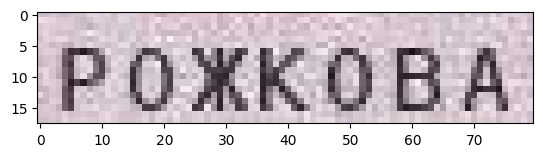

In [33]:
img = PIL.Image.open("dataset/crops/crop-999-surname1.jpg")
plt.imshow(img)

In [36]:
pixels = processor(img, return_tensors="pt").pixel_values
print(pixels.shape)
res = recognize_model(pixel_values=pixels)

torch.Size([1, 3, 224, 224])


ValueError: ignored